In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 4 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [4]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

# Heatmaps [FINAL]

In [5]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))

plot_col_dots = []
for query_model, context_model, POOLING in cfgs:
    dpr = YourCustomDEModel(query_model, context_model, POOLING)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    
    embds = dpr.encode_corpus(to_doc_format(df['sents_complete'].to_list()))
    query_embds = dpr.encode_queries(df['query'].to_list())
    embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
    new_col = f"{query_model}_dot"
    print(new_col)
    df[new_col] = embds_dot
    plot_col_dots.append(new_col)

  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/dragon-plus-query-encoder_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/dragon-roberta-query-encoder_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/contriever-msmarco_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
facebook/contriever_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
OpenMatch/cocodr-base-msmarco_dot


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)


  0%|          | 0/225 [00:00<?, ?it/s]

(7170, 768)
Shitao/RetroMAE_MSMARCO_finetune_dot


/tmp/ipykernel_3939382/1973214687.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")
/tmp/ipykernel_3939382/1973214687.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")
/tmp/ipykernel_3939382/1973214687.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(

head_count_digitized,"(0, 1]","(1, 2]","(2, 3]","(3, 10]"
gold_doc_len_digitized,,,,
"(230, 512]",41.245987,46.096626,50.207157,50.317993
"(190, 230]",42.999241,47.579926,51.156631,50.835094
"(160, 190]",43.499104,49.109730,50.503532,51.674225
"(130, 160]",44.429405,50.119900,51.732746,51.746304


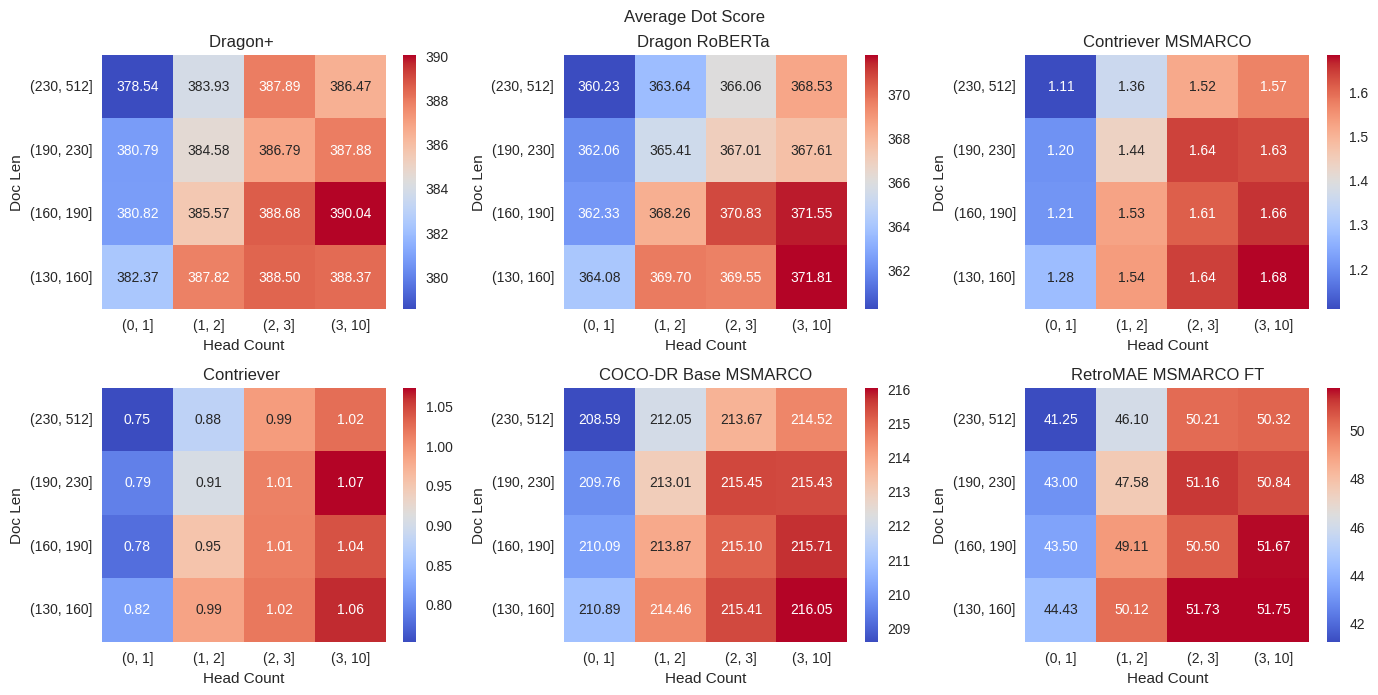

In [6]:
df["head_count"] = df["head_entity"].str.len()
bins = 5
bins_head = [0, 1, 2, 3, 10]
bins_doc = [130, 160, 190, 230, 512]
df["head_count_digitized"] = pd.cut(df["head_count"], bins=bins_head)
df["gold_doc_len_digitized"] = pd.cut(df["gold_doc_len"], bins=bins_doc)

# df = df[["head_entity", "head_count", "gold_doc_len", "head_count_digitized", "gold_doc_len_digitized"]]
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}

plt.figure(figsize=(14, 10))
for i, col in enumerate(plot_col_dots):
    plt.subplot(3, 3, i+1)
    dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")
    dfp = dfp.reindex(index=dfp.index[::-1])
    sns.heatmap(dfp, annot=True, fmt=".2f", cmap="coolwarm")
    model_name = model_mappings[col.split("_dot")[0]][0] + " " + model_mappings[col.split("_dot")[0]][1]
    plt.title(f"{model_name}")
    plt.ylabel("Doc Len")
    plt.xlabel("Head Count")
    # plt.show()
plt.suptitle("Average Dot Score")
plt.tight_layout()
plt.savefig("figs/repetition_heatmap.pdf")
dfp

/tmp/ipykernel_3939382/77219312.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="count")


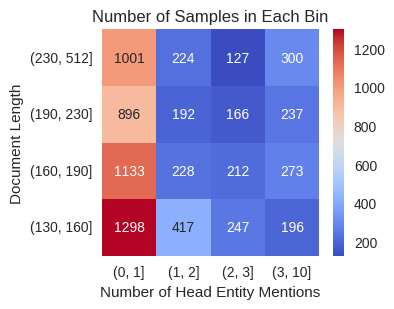

In [40]:
# for i, col in enumerate(plot_col_dots):
#     plt.figure(figsize=(4, 3.2))
#     dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="mean")
#     dfp = dfp.reindex(index=dfp.index[::-1])
#     sns.heatmap(dfp, annot=True, fmt=".2f", cmap="coolwarm")
#     model_name = model_mappings[col.split("_dot")[0]][0] + " " + model_mappings[col.split("_dot")[0]][1]
#     plt.title(f"Average Retrieval Score\n{model_name}")
#     plt.ylabel("Document Length")
#     plt.xlabel("Number of Head Entity Mentions")
#     plt.tight_layout()
#     plt.savefig(f"figs/repetition_heatmap_{model_name}.pdf")
#     plt.show()

plt.figure(figsize=(4, 3.2))
dfp = df.pivot_table(index="gold_doc_len_digitized", columns="head_count_digitized", values=col, aggfunc="count")
dfp = dfp.reindex(index=dfp.index[::-1])
sns.heatmap(dfp, annot=True, fmt=".0f", cmap="coolwarm")
model_name = model_mappings[col.split("_dot")[0]][0] + " " + model_mappings[col.split("_dot")[0]][1]
plt.title(f"Number of Samples in Each Bin")
plt.ylabel("Document Length")
plt.xlabel("Number of Head Entity Mentions")
plt.tight_layout()
plt.savefig(f"figs/repetition_heatmap_support.pdf")
plt.show()

# t-Test

In [54]:
df = df_raw.copy()
def flatten(xss):
    return [x for xs in xss for x in xs]

df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
print(len(df))

# df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
# df["head_wo_tail_sentence"] = df.apply(lambda r: " ".join(flatten([s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]])), axis=1)
df["head_sent_ids"] = df.apply(lambda r: sorted([h["sent_id"] for h in r["head_entity"]]), axis=1)
df["tail_sent_ids"] = df.apply(lambda r: sorted([t["sent_id"] for t in r["tail_entity"]]), axis=1)
df["head_sent_ids_wo_tail"] = df.apply(lambda r: [id for id in r["head_sent_ids"] if id not in r["tail_sent_ids"]], axis=1)
df["head_sent_ids_wo_tail_len"] = df["head_sent_ids_wo_tail"].apply(lambda x: len(x))
df["no_head_no_tail_sent_ids"] = df.apply(lambda r: [id for id in range(len(r["sents"])) if id not in r["head_sent_ids"] and id not in r["tail_sent_ids"]], axis=1)
df["no_head_no_tail_sent_ids_len"] = df["no_head_no_tail_sent_ids"].apply(lambda x: len(x))

SENTENCE_THRESHOLD = 2
df = df[df["head_sent_ids_wo_tail_len"] >= SENTENCE_THRESHOLD]  # >=2 Head Sentence
df = df[df["no_head_no_tail_sent_ids_len"] >= SENTENCE_THRESHOLD]  # >=2 No Head No Tail Sentence
print(len(df))

df = df.drop_duplicates(subset=["title"])
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

# df["sents_complete_wo_evidence"] = df.apply(lambda r: [s for i, s in enumerate(r["sents"]) if i not in [r["evidence_sent_ids"]][0]], axis=1)
# df["sents_complete_wo_evidence"] = df["sents_complete_wo_evidence"].apply(lambda x: " ".join(flatten(x)))
# df["sents_evidence"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
sents_cols = []
sents_cols.append(f"sents_less_heads")
sents_cols.append(f"sents_more_heads")
df["sents_less_heads"] = df.apply(lambda r: " ".join(flatten([r["sents"][r["tail_sent_ids"][0]]] + [r["sents"][i] for i in r["no_head_no_tail_sent_ids"]][:SENTENCE_THRESHOLD])), axis=1)
df["sents_more_heads"] = df.apply(lambda r: " ".join(flatten([r["sents"][r["tail_sent_ids"][0]]] + [r["sents"][i] for i in r["head_sent_ids_wo_tail"]][:SENTENCE_THRESHOLD])), axis=1)

print(df["title"].value_counts())

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + sents_cols
df[save_cols].to_json("dataset/repetition_bias.jsonl", orient="records", lines=True)

df.head(1)

2089
520
253
250
title
Kurt Tucholsky            1
Europafilm                1
Sarah Gibb                1
Cassels Lake              1
Samuel C. Brightman       1
                         ..
Assassin's Creed Unity    1
Waterloo Moraine          1
Abbas Kiarostami          1
PLATIT                    1
Durán, Ecuador            1
Name: count, Length: 250, dtype: int64


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,head_sent_ids,tail_sent_ids,head_sent_ids_wo_tail,head_sent_ids_wo_tail_len,no_head_no_tail_sent_ids,no_head_no_tail_sent_ids_len,sents_less_heads,sents_more_heads
4624,validation4465,When was Theobald Tiger born?,[Kurt Tucholsky],"{'Kurt Tucholsky': {'text': 'Kurt Tucholsky (; 9 January 1890 – 21 December 1935 ) was a German - Jewish journalist , satirist , and writer . He also wrote under the pseudonyms Kaspar Hauser ( after the historical figure ) , Peter Panter , Theobald Tiger and Ignaz Wrobel . Born in Berlin - Moabit , he moved to Paris in 1924 and then to Sweden in 1929 . Tucholsky was one of the most important journalists of the Weimar Republic . As a politically engaged journalist and temporary co - editor of the weekly magazine Die Weltbühne he proved himself to be a social critic in the tradition of Heinrich Heine . He was simultaneously a satirist , an author of satirical political revues , a songwriter and a poet . He saw himself as a left - wing democrat and pacifist and warned against anti - democratic tendencies – above all in politics , the military and justice – and the threat of National Socialism . His fears were confirmed when the Nazis came to power in January 1933 . In May of that year he was among the authors whose works were banned as "" un - German "" , and burned ; he was also among the first authors and intellectuals whose German citizenship was revoked .', 'title': 'Kurt Tucholsky'}}","{'len': 1000, 'max': 374.99981689453125, 'min': 366.4625244140625, 'std': 0.9724997556046819, 'mean': 367.3917474975586, 'median': 367.1249542236328}",{'Kurt Tucholsky': 367.18170166015625},"{'Theobald of Bec': 374.99981689453125, 'Theudebald': 373.9927062988281, 'Lionel Tiger': 373.4786682128906, 'Théophile Voirol': 373.07562255859375, 'Theobald Smith': 372.4722595214844, 'Jeremy Theobald': 372.0626220703125, 'Hugh Sinclair (actor)': 371.3525695800781, 'Tiger Haynes': 371.1489562988281, 'Theodore Brune': 371.07073974609375, 'Tassilo II of Bavaria': 371.0374755859375, 'Théobald Michau': 370.991455078125, 'Laurens Theodorus Gronovius': 370.8851623535156, 'Henry Trefflich': 370.8691101074219, 'Vincenzo Terranova': 370.8479919433594, 'Theopompus of Sparta': 370.7752685546875, 'Theodemir (Ostrogothic king)': 370.7596130371094, 'Théophile Bidard': 370.6140441894531, 'Tancred, Prince of Bari': 370.56085205078125, 'Pepsi Tate': 370.5372619628906, 'Tiger of Sabrodt': 370.52276611328125, 'Theo Findahl': 370.40594482421875, 'František Treybal': 370.2323303222656, 'Taktser Rinpoche': 370.13330078125, 'Frederick Triebel': 370.0704345703125, 'Stefan Effenberg': 370.0351257324219, 'Thoros III, King of Armenia': 370.00531005859375, 'Sombat Metanee': 369.9319152832031, 'Thomas Trood': 369.78656005859375, 'Gabriel Bertrand': 369.6939697265625, 'Tad Lincoln': 369.6448669433594, 'Tiger Town': 369.64093017578125, 'Tiruppur Kumaran': 369

In [48]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
df_dot.head(1)

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,head_sent_ids,tail_sent_ids,head_sent_ids_wo_tail,head_sent_ids_wo_tail_len,no_head_no_tail_sent_ids,no_head_no_tail_sent_ids_len,sents_less_heads,sents_more_heads,facebook/dragon-plus-query-encoder_sents_less_heads_dot,facebook/dragon-plus-query-encoder_sents_more_heads_dot,facebook/dragon-roberta-query-encoder_sents_less_heads_dot,facebook/dragon-roberta-query-encoder_sents_more_heads_dot,facebook/contriever-msmarco_sents_less_heads_dot,facebook/contriever-msmarco_sents_more_heads_dot,facebook/contriever_sents_less_heads_dot,facebook/contriever_sents_more_heads_dot,OpenMatch/cocodr-base-msmarco_sents_less_heads_dot,OpenMatch/cocodr-base-msmarco_sents_more_heads_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_less_heads_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_more_heads_dot
4624,validation4465,When was Theobald Tiger born?,[Kurt Tucholsky],"{'Kurt Tucholsky': {'text': 'Kurt Tucholsky (; 9 January 1890 – 21 December 1935 ) was a German - Jewish journalist , satirist , and writer . He also wrote under the pseudonyms Kaspar Hauser ( after the historical figure ) , Peter Panter , Theobald Tiger and Ignaz Wrobel . Born in Berlin - Moabit , he moved to Paris in 1924 and then to Sweden in 1929 . Tucholsky was one of the most important journalists of the Weimar Republic . As a politically engaged journalist and temporary co - editor of the weekly magazine Die Weltbühne he proved himself to be a social critic in the tradition of Heinrich Heine . He was simultaneously a satirist , an author of satirical political revues , a songwriter and a poet . He saw himself as a left - wing democrat and pacifist and warned against anti - democratic tendencies – above all in politics , the military and justice – and the threat of National Socialism . His fears were confirmed when the Nazis came to power in January 1933 . In May of that year he was among the authors whose works were banned as "" un - German "" , and burned ; he was also among the first authors and intellectuals whose German citizenship was revoked .', 'title': 'Kurt Tucholsky'}}","{'len': 1000, 'max': 374.99981689453125, 'min': 366.4625244140625, 'std': 0.9724997556046819, 'mean': 367.3917474975586, 'median': 367.1249542236328}",{'Kurt Tucholsky': 367.18170166015625},"{'Theobald of Bec': 374.99981689453125, 'Theudebald': 373.9927062988281, 'Lionel Tiger': 373.4786682128906, 'Théophile Voirol': 373.07562255859375, 'Theobald Smith': 372.4722595214844, 'Jeremy Theobald': 372.0626220703125, 'Hugh Sinclair (actor)': 371.3525695800781, 'Tiger Haynes': 371.1489562988281, 'Theodore Brune': 371.07073974609375, 'Tassilo II of Bavaria': 371.0374755859375, 'Théobald Michau': 370.991455078125, 'Laurens Theodorus Gronovius': 370.8851623535156, 'Henry Trefflich': 370.8691101074219, 'Vincenzo Terranova': 370.8479919433594, 'Theopompus of Sparta': 370.7752685546875, 'Theodemir (Ostrogothic king)': 370.

['facebook/dragon-plus-query-encoder_sents_less_heads_dot', 'facebook/dragon-plus-query-encoder_sents_more_heads_dot', 'facebook/dragon-roberta-query-encoder_sents_less_heads_dot', 'facebook/dragon-roberta-query-encoder_sents_more_heads_dot', 'facebook/contriever-msmarco_sents_less_heads_dot', 'facebook/contriever-msmarco_sents_more_heads_dot', 'facebook/contriever_sents_less_heads_dot', 'facebook/contriever_sents_more_heads_dot', 'OpenMatch/cocodr-base-msmarco_sents_less_heads_dot', 'OpenMatch/cocodr-base-msmarco_sents_more_heads_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_less_heads_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_more_heads_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low,ttest_ci_high,mean_diff,std_diff,n
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_more_heads_dot,facebook/contriever-msmarco_sents_less_heads_dot,5.564615,6.776179e-08,1.650996,1.650996,0.062724,0.178226,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_more_heads_dot,OpenMatch/cocodr-base-msmarco_sents_less_heads_dot,6.355194,9.847657e-10,1.650996,1.650996,0.924993,2.301333,250
0,Contriever,facebook/contriever_sents_more_heads_dot,facebook/contriever_sents_less_heads_dot,6.902427,4.221678e-11,1.650996,1.650996,0.052957,0.121308,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_more_heads_dot,facebook/dragon-plus-query-encoder_sents_less_heads_dot,6.929838,3.589540e-11,1.650996,1.650996,1.815411,4.142112,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_more_heads_dot,facebook/dragon-roberta-query-encoder_sents_less_heads_dot,7.978435,5.415030e-14,1.650996,1.650996,1.975561,3.915099,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_more_heads_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_less_heads_dot,8.051497,3.376018e-14,1.650996,1.650996,2.343101,4.601340,250


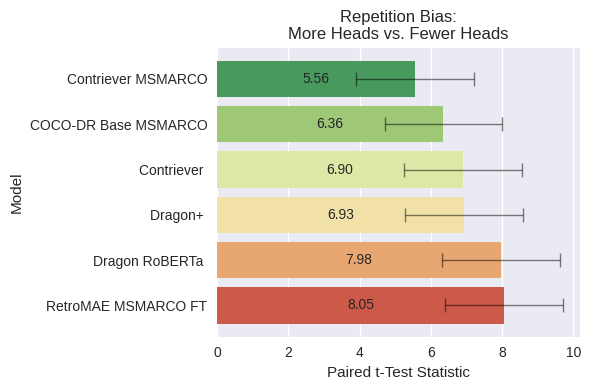

In [52]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and "more" in col1:
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": stats.ttest_rel(df[col1], df[col2])[0],
                    "ttest_pvalue": stats.ttest_rel(df[col1], df[col2])[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)
plt.figure(figsize=(6, 4))
plt.title("Repetition Bias:\nMore Heads vs. Fewer Heads")
ax = sns.barplot(data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
results_df.to_json("results/repetition_df.json", orient="records")
# ax.bar_label(ax.containers[0], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')
# ax.bar_label(ax.containers[1], labels=[f"{s:.2f}" for s, p in zip(results_df["Paired t-Test Statistic"], results_df["ttest_pvalue"])], fontsize=10, fmt='%.2f', label_type='center', color='white')

plt.tight_layout()
plt.savefig("figs/repetition_ttest.pdf")
results_df

In [51]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_sents_more_heads_dot"] - df["facebook/dragon-plus-query-encoder_sents_less_heads_dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["evidence_len"].describe())
df = df[df["evidence_len"] < 20]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff"]].sort_values("diff", ascending=False)

count    250.000000
mean      26.848000
std       10.491577
min        6.000000
25%       20.000000
50%       26.000000
75%       32.000000
max       88.000000
Name: evidence_len, dtype: float64


,sents_less_heads,sents_more_heads,title,query,evidence_text,gold_doc_len,diff
1256,"He has taught at Makerere University in Kampala , Uganda , as well as at Northwestern University . His music combines elements of traditional Ugandan music and Western music . He is best known for his first string quartet , which was included by the Kronos Quartet on their 1992 CD Pieces of Africa , which contains music by seven African composers .","He has taught at Makerere University in Kampala , Uganda , as well as at Northwestern University . Justinian Tamusuza ( born 1951 ) is a Ugandan composer of contemporary classical music . Tamusuza was born in Kibisi .",Justinian Tamusuza,Which country is Justinian Tamusuza a citizen of?,Justinian Tamusuza ( born 1951 ) is a Ugandan composer of contemporary classical music .,153,21.545166
5361,"It was animated by Studio Ghibli for Tokuma Shoten and the Nippon Television Network . The film is set in the city of Kōchi , on the Japanese island of Shikoku . It concerns a love triangle that develops between two good friends and a new girl who transfers to their high school from Tokyo .","It was animated by Studio Ghibli for Tokuma Shoten and the Nippon Television Network . Ocean Waves , also known as , is a 1993 Japanese anime television film directed by Tomomi Mochizuki and written by Kaori Nakamura based on the 1990 novel of the same name by Saeko Himuro . Ocean Waves , also known as , is a 1993 Japanese anime television film directed by Tomomi Mochizuki and written by Kaori Nakamura based on the 1990 novel of the same name by Saeko Himuro .",Ocean Waves (film),What is the original network of Ocean Waves?,"Ocean Waves first aired on May 5 , 1993 on Nippon TV .",176,12.397095
3872,"Esch had a farming business and did a Ph.D. in business administration at Uppsala University in 1972 . Before joining the Christian Democrats , he had previously represented Moderate Party in the Riksdag 1991 – 1994 , replacing Per Westerberg during his time as a minister . When he subsequently formed a list of EU critics that ran in the 1995 European Parliament election in Sweden , he was expelled from the party .","Esch had a farming business and did a Ph.D. in business administration at Uppsala University in 1972 . Carl Gösta Björn Joachim von der Esch ( 11 January 1930 – 10 March 2010 ) was a Swedish Christian democratic politician , member of the Riksdag 1998 – 2006 . At the time of the Swedish 1994 referendum on membership in the European Union , Esch clashed with the Moderate Party as he campaigned on the "" no "" side .",Björn von der Esch,Where was Carl Gösta Björn Joachim von der Esch educated?,Esch had a farming business and did a Ph.D. in business administration at Uppsala University in 1972 .,230,12.047058
6457,"Excitebots was unveiled in a release list from Nintendo of America on February 26 , 2009 . It was developed by Monster Games , is the fourth main game in the Excite series and is the sequel to Excite Truck . It was released on April 20 , 2009 in North America .","Excitebots was unveiled in a release list from Nintendo of America on February 26 , 2009 . Excitebots : Trick Racing , known in Japan as , is a racing video game published by Nintendo for the Wii video game console . Excitebots features animal - themed robot vehicles and short minigames during racing , such as pie throwing , bowling and soccer .",Excitebots: Trick Racing,Who is the publisher of Excitebots : Trick Racing?,"Excitebots was unveiled in a release list from Nintendo of America on February 26 , 2009 .",186,10.438263
4361,Silvan ( wood elves ) are a type of Elves in J.R.R. They are commonly known as Wood - elves . Many of them were later ruled over by a small population of social elites who were Sindar ( Grey Elves ) or even Noldor ( High Elves ) .,"Silvan ( wood elves ) are a type of Elves in J.R.R. Silvan Elves are mainly Nandor in descent but also mixed with Avari . Silvan Elves are described as being less wise than other Eldar , and

# More

In [ ]:
# sns.heatmap(df[["head_count", "gold_doc_len", "gold_doc_score"]].pivot(index="head_count", columns="gold_doc_len", values="gold_doc_score"), annot=True, cmap="coolwarm", fmt=".2f")
# sns.histplot(df, x="head_count", y="gold_doc_len")
# plt.ylim(120, 250)
sns.pairplot(df[["head_count", "gold_doc_len", "gold_doc_score"]])
# sns.violinplot(data=df, x="head_count", y="gold_doc_score", inner_kws=dict(box_width=7, whis_width=2, color=".8"))
# sns.violinplot(data=df, x="gold_doc_len", y="gold_doc_score", inner_kws=dict(box_width=7, whis_width=2, color=".8"))

In [ ]:
sns.histplot(df["gold_doc_len"], bins=50)

In [ ]:
df2 = df.copy().dropna()

plt.scatter(df2["head_count"], df2["gold_doc_len"], s=10 * np.maximum(0, df2["gold_doc_score"] - 380), alpha=0.05)

In [ ]:
df2 = df.copy().dropna()
df2 = df2[df2["head_count"] < 5]
sns.scatterplot(data=df2, x="gold_doc_len", y="gold_doc_score", hue="head_count", palette="coolwarm", alpha=0.4, size=0.2)